In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import folium
import rasterio as rio
import tifffile as tiff
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# Global Power Plant Database

The island of Puerto Rico has multiple power plants for its energy generation. We will begin by seeing where these power plants are.

In [2]:
#Insert eie data path below
eie_data_path = 'eie_data'
gpp_df = pd.read_csv(eie_data_path+'/gppd/gppd_120_pr.csv')
gpp_df.head()

,system:index,capacity_mw,commissioning_year,country,country_long,estimated_generation_gwh,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,...,other_fuel1,other_fuel2,other_fuel3,owner,primary_fuel,source,url,wepp_id,year_of_capacity_data,.geo
0,0000000000000000315a,15.0,1942.0,USA,United States of America,685.397712,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,PREPA,Hydro,CEPR,http://energia.pr.gov/datos/plantas/,30936.0,0,"{""type"":""Point"",""coordinates"":[-66.66629863706..."
1,000000000000000026e5,1492.0,1975.0,USA,United States of America,8334.010812,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,PREPA,Oil,PREPA,http://www.prepa.com/aguirre.asp,30928.0,0,"{""type"":""Point"",""coordinates"":[-66.23079607357..."
2,00000000000000002fda,990.0,1962.0,USA,United States of America,5529.940150,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,PREPA,Oil,PREPA,http://www.prepa.com/costasur.asp,30934.0,0,"{""type"":""Point"",""coordinates"":[-66.75340271704..."
3,00000000000000003f76,602.0,1960.0,USA,United States of America,3362.650475,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,PREPA,Oil,PREPA,http://www.prepa.com/PALOSECO.ASP,30942.0,0,"{""type"":""Point"",""coordinates"":[-66.14859700475..."
4,00000000000000002def,10.0,1915.0,USA,United States of America,456.931808,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,PREPA,Hydro,PREPA,http://www.prepa.com/historia_eng.asp https:/...,65289.0,0,"{""type"":""Point"",""coordinates"":[-66.10600367149..."


In [3]:
#code source: https://www.kaggle.com/paultimothymooney/overview-of-the-eie-analytics-challenge
def plot_points_on_map(dataframe,begin_index,end_index,latitude_column,latitude_value,longitude_column,longitude_value,zoom):
    df = dataframe[begin_index:end_index]
    location = [latitude_value,longitude_value]
    plot = folium.Map(location=location,zoom_start=zoom)
    for i in range(0,len(df)):
        popup = folium.Popup(str(df.primary_fuel[i:i+1]))
        folium.Marker([df[latitude_column].iloc[i],df[longitude_column].iloc[i]],popup=popup).add_to(plot)
    return(plot)

def overlay_image_on_puerto_rico(file_name,band_layer,lat,lon,zoom):
    band = rio.open(file_name).read(band_layer)
    m = folium.Map([lat, lon], zoom_start=zoom)
    folium.raster_layers.ImageOverlay(
        image=band,
        bounds = [[18.6,-67.3,],[17.9,-65.2]],
        colormap=lambda x: (1, 0, 0, x),
    ).add_to(m)
    return m

def plot_scaled(file_name):
    vmin, vmax = np.nanpercentile(file_name, (5,95))  # 5-95% stretch
    img_plt = plt.imshow(file_name, cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()

def split_column_into_new_columns(dataframe,column_to_split,new_column_one,begin_column_one,end_column_one):
    for i in range(0, len(dataframe)):
        dataframe.loc[i, new_column_one] = dataframe.loc[i, column_to_split][begin_column_one:end_column_one]
    return dataframe

gpp_df = split_column_into_new_columns(gpp_df,'.geo','latitude',50,66)
gpp_df = split_column_into_new_columns(gpp_df,'.geo','longitude',31,48)
gpp_df['latitude'] = gpp_df['latitude'].astype(float)
a = np.array(gpp_df['latitude'].values.tolist()) # 18 insted of 8
gpp_df['latitude'] = np.where(a < 10, a + 10, a).tolist()
lat = 18.200178; lon = -66.664513
plot_points_on_map(gpp_df, 0, 425, 'latitude', lat, 'longitude', lon, 9)

In [4]:
print('There are ', gpp_df.shape[0],' power plants')

There are  35  power plants


Let's check the most important plants (electricity generation)

In [5]:
gpp_df.head()

,system:index,capacity_mw,commissioning_year,country,country_long,estimated_generation_gwh,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,...,other_fuel3,owner,primary_fuel,source,url,wepp_id,year_of_capacity_data,.geo,latitude,longitude
0,0000000000000000315a,15.0,1942.0,USA,United States of America,685.397712,0.0,0.0,0.0,0.0,...,NaN,PREPA,Hydro,CEPR,http://energia.pr.gov/datos/plantas/,30936.0,0,"{""type"":""Point"",""coordinates"":[-66.66629863706...",18.335899,-66.6662986370627
1,000000000000000026e5,1492.0,1975.0,USA,United States of America,8334.010812,0.0,0.0,0.0,0.0,...,NaN,PREPA,Oil,PREPA,http://www.prepa.com/aguirre.asp,30928.0,0,"{""type"":""Point"",""coordinates"":[-66.23079607357...",17.951899,-66.2307960735768
2,00000000000000002fda,990.0,1962.0,USA,United States of America,5529.940150,0.0,0.0,0.0,0.0,...,NaN,PREPA,Oil,PREPA,http://www.prepa.com/costasur.asp,30934.0,0,"{""type"":""Point"",""coordinates"":[-66.75340271704...",18.000298,-66.7534027170407
3,00000000000000003f76,602.0,1960.0,USA,United States of America,3362.650475,0.0,0.0,0.0,0.0,...,NaN,PREPA,Oil,PREPA,http://www.prepa.com/PALOSECO.ASP,30942.0,0,"{""type"":""Point"",""coordinates"":[-66.14859700475...",18.455301,-66.1485970047576
4,00000000000000002def,10.0,1915.0,USA,United States of America,456.931808,0.0,0.0,0.0,0.0,...,NaN,PREPA,Hydro,PREPA,http://www.prepa.com/historia_eng.asp https:/...,65289.0,0,"{""type"":""Point"",""coordinates"":[-66.10600367149...",18.044702,-66.1060036714951


In [6]:
#For the purposes of the model, we will use estimated power generation in gwh as a feature
total_power_generation_2017 = gpp_df['estimated_generation_gwh'].sum()
print('The total estimated power generation for all power plants in puerto for 2017 rico is: ', total_power_generation_2017, ' gwh')

The total estimated power generation for all power plants in puerto for 2017 rico is:  486860.87514460966  gwh


## Sentinel-5 Precursor Data

The Sentinel-5 Precuror satellite has sensors to gauge NO2 concentrations. Below we will visualize the NO2 concentrations and display them over the island of Puerto Rico. 

In [7]:
no2_emissions_image = eie_data_path+'/s5p_no2/s5p_no2_20180701T161259_20180707T175356.tif'
latitude=18.1429005246921; longitude=-65.4440010699994
overlay_image_on_puerto_rico(no2_emissions_image,band_layer=1,lat=latitude,lon=longitude,zoom=8)

In the image above, we are overlaying the first band of an image taken on July 7th, 2017 over the island of Puero Rico. The overlayed image (in red) displays the total vertical column of NO 2 in mol/m^2. The shade of red varies based on the quantity. Below there is a similar overlay for band 2 (measurements of the vertical column of NO 2 for the troposphere).

In [9]:
overlay_image_on_puerto_rico(no2_emissions_image,band_layer=2,lat=latitude,lon=longitude,zoom=8)

### First Simple Model

An Emissions Factor is a value that relates the quanity of a pollutant in the atmosphere with an activity associated with the release of that pollutant. 

We can calculate emissions using the following equation: 

E = A * EF * (1 - ER / 100 )

Here A refers to an activity, EF is the emissions factor, and ER is the overall emissions reduction efficiency (percentage value). 

If we solve for the Emissions Factor:

EF = (E * 100) / (A * (1-ER))

By solving for the EF, we can try to calculate the factor for the power plant data

From the Sentinel Satellite, NO2 emissions are measured in band1, band2, band3 and band4. The total emissions (E) for a given day (each tif file for emissions is a snapshot for a single day), can be calculated by summing these four bands).

The Activity for which we're interested in is the energy generation from power plants. One way to calculate the emissions factor for the energy generation would be to use the activity from all the power plants as A, and assume that the emissions reduction efficiency is 0. Therefore:

EF = (E) / (A)

In [10]:
activity = total_power_generation_2017
#Using the emissions snapshot from above
no2_emissions_sum = tiff.imread(no2_emissions_image)[:,:,0:4].sum()
emissions_factor = (no2_emissions_sum ) / (total_power_generation_2017)
print("Emissions Factor for power plant energy generation activity : ", emissions_factor)

Emissions Factor for power plant energy generation activity :  3.88689431971722e-05


We have calculated the emissions factor to be 3.886 * 10^-5. This is a very rough estimate of the emissions factor. This model makes many assumptions:

- It does not take any spatial information into account, i.e. the original NO2 emissions data has measurements over the entire island of Puerto Rico. The emissions (as seen in the overlayed map), vary based on the location. Instead emissions over the entire island are summed. Similar to the NO2 emissions, the power plants total power generation does not take spatial information into account (the activity is not uniform over the entire island). Due to these assumptions, it is assumed that only energy generation activity from power plants contributes to the generation of NO2 emissions.

- The emissions are only from a single date. Emissions vary from day to day, and this information is lost. Similarly activity data is also not of a single day instead it is just a summation of all the activity from the power plants. 


### Feature Engineering

To assess what factors contribute to emissions, a model can be built to predict the NO2 emissions. The features of the model can be activities that sources of NO2, and/or causes of the spread of NO2. 

We will create features from the NO2 emissions, weather, land assimilation data, and power plant data. 

In [11]:
#Get the date information from each files name
def get_dates(file_path, data_source):
    if data_source == 's5p':
        fname_only = file_path.split('/')
        dates_only = (fname_only[-1].split('_')[2], fname_only[-1].split('_')[3])
        start_date = dates_only[0][:8]
        end_date = dates_only[1][:8]
        return start_date, end_date
    elif data_source == 'gfs':
        file_name = file_path.split('/')[-1]
        date_w_extension = file_name.split('_')[-1]
        date = date_w_extension.split('.')[0][:8]
        return date
    elif data_source == 'gldas':
        file_name = file_path.split('/')[-1]
        date = file_name.split('_')[1]
        return date
    
#Read the data from the files and assemble a dataframe 
def read_data(data_path,data_source):
    data = []
    for file in os.listdir(data_path):
        file_path = data_path+file
        img = tiff.imread(file_path)
        img_to_add = {}
        if data_source == 's5p':
            start_date, end_date = get_dates(file_path, 's5p')
            img_to_add['start_date'] = start_date
            img_to_add['end_date'] = end_date
            img_to_add['no2_emissions_mean'] = np.nanmean(img[:,:,0:4])
        elif data_source == 'gfs':
            img_to_add['date'] = get_dates(file_path, 'gfs')
            img_to_add['temp'] = img[:,:,0]
            img_to_add['specific_humidity'] = img[:,:,1]
            img_to_add['relative_humidity'] = img[:, :, 2]
            img_to_add['u_component_wind'] = img[:, :, 3]
            img_to_add['v_component_wind'] = img[:, :, 4]
            img_to_add['total_precipation'] = img[:, :, 5]
        elif data_source == 'gldas':
            img_to_add['date'] = get_dates(file_path, 'gldas')
            for band in range(1, 13):
                img_to_add['band'+str(band)] = rio.open(file_path).read(band)    
                
        data.append(img_to_add)
        data_df = pd.DataFrame(data)
        
        if data_source == 's5p':
            data_df['start_date'] = pd.to_datetime(data_df['start_date'])
            data_df['end_date'] = pd.to_datetime(data_df['end_date'])
            data_df.sort_values('start_date', inplace = True)
            data_df.reset_index(drop = True, inplace = True)
        else: 
            data_df['date'] = pd.to_datetime(data_df['date'])
            data_df.sort_values('date', inplace=True)
       
    return data_df

##### Getting Labels for Regression Model from Sentinel Satellite

In [15]:
no2_path = eie_data_path+'/s5p_no2/'
print("Number of sentinel satellite pictures: ", len(os.listdir(no2_path)))

Number of sentinel satellite pictures:  387


Below, we'll get the the data from .tif files that contain NO2 measurements of the Sentinel Satellite. We'll create a pandas dataframe that will have the mean no2 emissions. 

In [16]:
emissions_mean = read_data(no2_path, 's5p')
emissions_mean.head()

,start_date,end_date,no2_emissions_mean
0,2018-07-01,2018-07-07,0.000067
1,2018-07-02,2018-07-08,0.000066
2,2018-07-04,2018-07-10,0.000058
3,2018-07-05,2018-07-12,0.000058
4,2018-07-06,2018-07-12,0.000063


Below is a plot of the emissions mean (Y axis), and the start date on the x axis. We see that emissions peak just before May, followed by additonal peaks during June, July, and August.

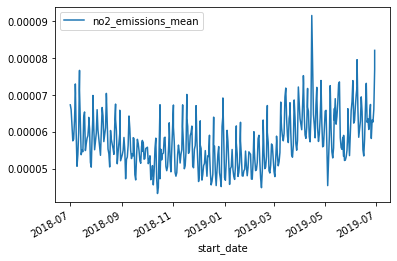

In [17]:
emissions_mean.plot.line(x='start_date', y='no2_emissions_mean')

##### Features from Atmosphere Data (Global Forecast System 384-Hour Predicted Atmosphere Data) 

In [18]:
gfs_path = eie_data_path + '/gfs/'
print("We have " , len(gfs_path), " pictures of the global forecast system")
weather_df = read_data(gfs_path, 'gfs')
weather_df.head()

We have  73  pictures of the global forecast system


,date,temp,specific_humidity,relative_humidity,u_component_wind,v_component_wind,total_precipation
237,2018-07-01,"[[26.650018310546898, 26.650018310546898, 26.6...","[[0.01647000014781952, 0.01647000014781952, 0....","[[75.80000305175781, 75.80000305175781, 75.800...","[[-5.701642990112305, -5.701642990112305, -5.7...","[[-1.1736425161361694, -1.1736425161361694, -1...","[[29.100000381469727, 29.100000381469727, 29.1..."
52,2018-07-01,"[[26.550012207031273, 26.550012207031273, 26.5...","[[0.017090000212192535, 0.017090000212192535, ...","[[79.4000015258789, 79.4000015258789, 79.40000...","[[-6.701745510101318, -6.701745510101318, -6.7...","[[-1.2836816310882568, -1.2836816310882568, -1...","[[31.700000762939453, 31.700000762939453, 31.7..."
1240,2018-07-01,"[[27.650018310546898, 27.650018310546898, 27.6...","[[0.01793999969959259, 0.01793999969959259, 0....","[[77.82247924804688, 77.82247924804688, 77.822...","[[-5.73009729385376, -5.73009729385376, -5.730...","[[-6.115441799163818, -6.115441799163818, -6.1...","[[35.10000228881836, 35.10000228881836, 35.100..."
787,2018-07-01,"[[27.319757080078148, 27.319757080078148, 27.3...","[[0.01800999976694584, 0.01800999976694584, 0....","[[79.80000305175781, 79.80000305175781, 79.800...","[[-8.028334617614746, -8.028334617614746, -8.0...","[[-2.408210277557373, -2.408210277557373, -2.4...","[[36.065364837646484, 36.065364837646484, 36.0..."
488,2018-07-02,"[[27.038964843750023, 27.038964843750023, 27.0...","[[0.018069999292492867, 0.018069999292492867, ...","[[81.5, 81.5, 81.5, 81.5, 81.5, 81.5, 81.5, 81...","[[-7.756444931030273, -7.756444931030273, -7.7...","[[-2.424609422683716, -2.424609422683716, -2.4...","[[37.20000076293945, 37.20000076293945, 37.200..."


In [19]:
def get_weather_feature_stats(df):
    for c in [col for col in df.columns if col not in ['date']]:
        df[c] = df[c].apply(np.mean)
    return df
weather_mean_stats = get_weather_feature_stats(weather_df.copy())
weather_mean_stats.head()

,date,temp,specific_humidity,relative_humidity,u_component_wind,v_component_wind,total_precipation
237,2018-07-01,26.721326,0.015933,72.501199,-3.198577,-1.064460,29.777113
52,2018-07-01,24.654592,0.015828,81.975105,-3.046369,-0.986729,30.464020
1240,2018-07-01,29.591174,0.016797,65.249798,-4.041724,-0.803598,33.662348
787,2018-07-01,25.825862,0.016881,81.037281,-3.423931,-1.518467,32.592481
488,2018-07-02,25.821642,0.017302,82.992838,-3.458926,-1.000598,33.521104


In the DataFrame above you can see that each date as a atmosphere feature associated with it, i.e. temperature, humidity, etc. Below, there are plots of the different atmosphere features. There are multiple measurements per day, and we can see an overall trend in the data corresponding with the feature value and date.

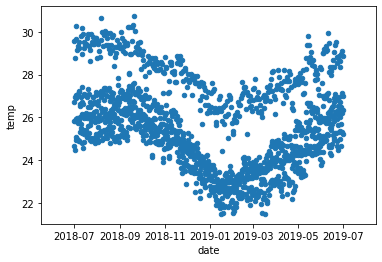

In [20]:
#DOES NOT WORK IN KAGGLE NOTEBOOK
weather_mean_stats.plot.scatter(x='date',y='temp')

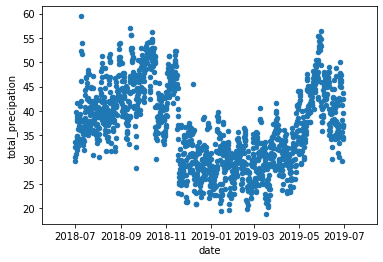

In [21]:
weather_mean_stats.plot.scatter(x='date',y='total_precipation')

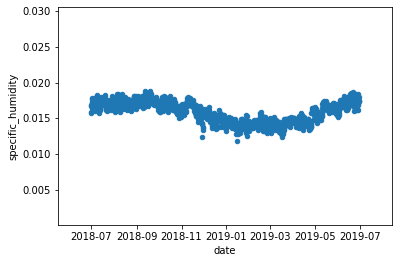

In [22]:
weather_mean_stats.plot.scatter(x='date',y='specific_humidity')

##### Beginning to assemble the dataset for our model

Below, we'll start building our dataset for our model. The dataset will have m examples in total, where m is the number of dates that correspond to the NO2 emissions measurements. 

In [24]:
#As there are multiple weather measurements per day, group them by the date and take the mean
weather_features = weather_mean_stats.groupby('date').mean()
#Also group the emissions  by date 
emissions_mean = emissions_mean.groupby('start_date').mean()

In [25]:
#concatenate the mean emissions dataframe and the weather features
training_data = pd.concat([weather_features, emissions_mean], axis=1 , join='outer')
#Drop any NaN values
training_data.dropna(how='any',inplace=True)
training_data.head()

,temp,specific_humidity,relative_humidity,u_component_wind,v_component_wind,total_precipation,no2_emissions_mean
2018-07-01,26.698238,0.016360,75.190846,-3.427650,-1.093313,31.623991,0.000067
2018-07-02,26.502170,0.017176,79.500569,-3.063298,-0.446986,34.462254,0.000066
2018-07-04,26.892851,0.016908,76.759937,-4.791763,-0.492622,36.685696,0.000058
2018-07-05,26.783559,0.016893,77.301614,-4.255460,-1.008936,35.369304,0.000058
2018-07-06,26.768654,0.016544,75.760273,-4.269123,-0.749186,37.137468,0.000063


##### Features from Global Land Data Assimilation System

In [26]:
gldas_path = eie_data_path + '/gldas/'
print("We have ", len(os.listdir(gldas_path)), " pictures of land data")

We have  2920  pictures of land data


In [ ]:
gldas_df = read_data(gldas_path, 'gldas')

In [ ]:
gldas_df.head()

In [ ]:
def get_gldas_mean_stats(df):
    cols = [col for col in df.columns if col not in ['date']]
    print(cols)
    for c in cols:
        df[c] = df[c].apply(np.mean)
    return df
gldas_mean_stats = get_gldas_mean_stats(gldas_df.copy())
gldas_mean_stats['date'] = gldas_mean_stats['date'].apply(pd.Timestamp.date)
gldas_mean_stats = gldas_mean_stats.fillna(0)
gldas_mean_stats = gldas_mean_stats.groupby('date').mean()

In [ ]:
training_data = pd.concat([training_data, gldas_mean_stats], axis=1 , join='outer')
training_data.dropna(how='any', inplace=True)
#Add the total power generation of all the power plants
training_data['total_power_generation'] = total_power_generation_2017
training_data.head()

### Linear Regression

For a regression model, our goal is to predict the NO2 emissions by using features engineered from power plant, atmosphere, and land use data. There are many factors that contribute to NO2 emissions. While there are sources of pollution such as electricty/power generation, traffic, and other industrial activities, conditions of land and the atmosphere can affect how pollutants remain in, and spread from the environment that they originate from.

For each given day we have the average of the NO2 emissions of that day, and the weather and land information as well. Features from weather data include the mean temperature, specific humidity, relative humidity, the U component of the wind, the V component of the wind, and the total precipation at surface. Similarly, the features from the land assimilation data include albedo, average surface skin temperature, plant canopy surface water, canpoy water evaporation, evaporation from bare soil, evapotranspiration, downward long-wave radiation flux, net long-wave radiation flux, potential evaporation rate, pressure, specific humidity, and heat flux (first 12 bands).There is not time series data available- so the total power generation of the entire island of Puerto Rico will be assumed to be constant (for the time being).

Measurements from s5p (NO2 emissions), weather, and land originally provide data for the entire island. For the purpose of the regression, we average the measurement accross the entire island. This does result in loss of spatial information, and is a much more coarse.


In [ ]:
ds = training_data.copy()
train_df = ds.iloc[:324]
test_df = ds[324:]
X = train_df[[col for col in ds.columns if col not in ['no2_emissions_mean']]]
Y = train_df['no2_emissions_mean']
model = LinearRegression().fit(X,Y)
test_X = test_df[[col for col in ds.columns if col not in ['no2_emissions_mean']]]
test_Y = test_df['no2_emissions_mean']
preds = model.predict(test_X)
preds = pd.Series(preds)

In [ ]:
plt.plot(preds.index, preds.values, color='red')

In [ ]:
plt.plot(test_Y.index, test_Y.values)

In [ ]:
rms = np.sqrt(mean_squared_error(test_Y, preds))

In [ ]:
print(rms)

Based on the above we can see that there is room for improvement for the regression model. Future model improvements can include using more features from power plant/activity, weather, and land use data in addition to incorporating spatial information of emissions.